Your first simulation using OpenMM.
----------------------------------

We first import the "application layer" of `OpenMM`---
it is a collection of libraries written in Python, which, when chained together,
create Python programs that run simulations.

If you didn't have previous programming experience in Python,
you can simply treat this layer as the "scripts" you used in `bash` when
you use more traditional simulation packages.
If you did, you will see that `OpenMM` adheres to the design principles of 
object-oriented programming, where components of simulation are abstracted as
objects.


In [2]:
import openmm
from openmm import app, unit

Also imported at this stage is the `unit` module of `OpenMM`.
To be explicit about the units of the simulations is a crucial design choice of
`OpenMM`.
This helps alleviate any confusions in analyzing the results.

As such, quantities with units attached can easily enter the computation,
for example:


In [4]:
1 * unit.kilocalorie_per_mole / unit.kilojoule_per_mole

4.184

Check out this amazing package, 🍻[pint](https://pint.readthedocs.io/en/0.7.2/systems.html), 
if you also wanted to implement unit system in your scientific computing.

### System preparation

We grab a very toyish🧸 system---alanine dipeptide (which, [like it or not](https://pubs.acs.org/doi/10.1021/ct800153n), is one of the simplest system all computational biophysicists use) and save as a [PDB](https://www.rcsb.org/docs/programmatic-access/file-download-services) file. 

In [5]:
import urllib
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/openmm/openmm/master/wrappers/python/tests/systems/alanine-dipeptide-explicit.pdb",
    "input.pdb"
)

('input.pdb', <http.client.HTTPMessage at 0x116bef850>)

We can then read this file into the memory, using the `app` layer of `OpenMM`:

In [6]:
pdb = app.PDBFile('input.pdb')

### Force field specification

Now we have defined the structure of the system, we define the force field with which we will simulate it.
In this case it's the [Amber14](http://ambermd.org) force field alongside with [TIP3P](https://pubs.acs.org/doi/10.1021/jp003020w) water model.
Note that water molecules are already included for the input this time;
in the next example we'll ask you to manually add that.

In [7]:
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

With everything defined, we can go ahead and create the system, with [particle mesh Ewald](https://en.wikipedia.org/wiki/Ewald_summation) as the nonbonded method.

In [8]:
system = forcefield.createSystem(
    pdb.topology, 
    nonbondedMethod=app.PME,
    nonbondedCutoff=1*unit.nanometer, 
    constraints=app.HBonds,
)

### Integrator specification

Next, we specify a [Langevin](https://en.wikipedia.org/wiki/Langevin_dynamics) integrator, 
which is another crucial component of molecular dynamcis (MD) simulation.
Check out other flavors of integrators [here](http://docs.openmm.org/latest/api-python/library.html#integrators). 

Here you can specify the temperature, the friction coefficient, and the step size of the integrator
to correspond to your simulation needs.
A safe choice is:

In [26]:
integrator = openmm.LangevinIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds,
)

### Putting the objects together for the simulation

It's now time to put everything together to form a simulation object.

In [17]:
simulation = app.Simulation(pdb.topology, system, integrator)

So far, we have only defined the _structure, or topology_ of the system,
now we also grab the _positions, or coördinates_ from the `pdb` file.

In [19]:
simulation.context.setPositions(pdb.positions)

Since there could be some regions in the `pdb` file with high energy conformations
(for instance, clashes), we first minimize the energy before starting the simulation.

In [20]:
simulation.minimizeEnergy()

Now we are ready for the simulation, we also need a way to record the simulation
for further analysis (otherwise what's the point of simulating 😊).
To do so, we attach a PDB reporter to the simulation, with appropriate recording interval.
A smaller interval correspond to richer information but more intensive memory usage.

In [46]:
simulation.reporters.append(app.PDBReporter('output.pdb', 100))

It's time to officially hit the run button.
Note that the number of steps times the step size (specified above) is the total amount of time to be simulated.
Many  event cannot be simulated until the simulation is long enough.
But here we only simulate for a short period of time to get our hands dirty. 👋

In [31]:
simulation.step(10000)

⏳ Voilà! The simulation is done.

Now we use [`MDTraj`](https://www.mdtraj.org/1.9.8.dev0/index.html) to analyze the trajectory:
first we simply load the output trajectory.

In [28]:
import mdtraj as md
traj = md.load('output.pdb')

You can visually inspect the movie using [`NGLView`](https://github.com/arose/nglview).

In [49]:
import nglview
view = nglview.show_mdtraj(traj)

One of the first thing we can check about the simluation is the rooted-mean-square-distance (RMSD)
of the snapshots w.r.t. the first snapshot, which tells us whether the simulation is stable:

Text(0, 0.5, 'RMSD (nm)')

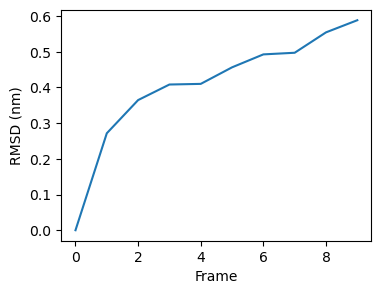

In [30]:
from matplotlib import pyplot as plt
rmsd = md.rmsd(traj, traj, 0)
plt.figure(figsize=(4, 3))
plt.plot(rmsd)
plt.xlabel('Frame')
plt.ylabel('RMSD (nm)')

You can also compute a wide range of physical properties using MDTraj.

In [29]:
md.compute_J3_HN_C(traj); # Compute J couplings in the HN-C plane, which can be observed using NMR spectroscopy
md.density(traj); # Compute the density of the system
md.shrake_rupley(traj); # Compute the solvent-accessible surface area of the system